
# EDA — Algo Trading Preprocessed Data

Набор визуализаций для быстрого осмотра датасета после препроцессинга (по статье Alsulmi & Al‑Shahrani, 2022).
Заполни путь к файлу и запускай по порядку.


In [1]:

# --- Config ---
PREPPED_PATH = "data/preprocessed/preprocessed_SBER.csv"   # Укажи путь к твоему файлу

# --- Imports ---
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

# Matplotlib settings (минимальные)
plt.rcParams["figure.figsize"] = (9, 4)
plt.rcParams["axes.grid"] = True

# Helper: safe column selector
def num_features(df, exclude=("label","ticker","date")):
    cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return [c for c in cols if c not in exclude]

def show_acf(series, nlags=30, title="ACF"):
    x = series.values.astype(float)
    x = x[np.isfinite(x)]
    x = x - np.nanmean(x)
    n = len(x)
    if n < nlags + 1:
        nlags = max(1, n - 1)
    acf = [1.0]
    denom = np.dot(x, x)
    for lag in range(1, nlags + 1):
        num = np.dot(x[:-lag], x[lag:])
        acf.append(num / denom if denom != 0 else np.nan)
    fig = plt.figure()
    plt.stem(range(nlags+1), acf, use_line_collection=True)
    plt.title(title)
    plt.xlabel("lag")
    plt.ylabel("acf")
    plt.show()


In [2]:

# --- Load ---
assert Path(PREPPED_PATH).exists(), f"Файл не найден: {PREPPED_PATH}"
df = pd.read_csv(PREPPED_PATH)
# Попробуем парсить дату
if "date" in df.columns:
    try:
        df["date"] = pd.to_datetime(df["date"])
    except Exception:
        pass

print("Shape:", df.shape)
print("Columns:", len(df.columns))
print(df.head(3))
print("\nTickers:", df.get("ticker", pd.Series()).nunique() if "ticker" in df.columns else "N/A")
print("Date range:", (df["date"].min(), df["date"].max()) if "date" in df.columns else "N/A")
if "label" in df.columns:
    print("\nLabel balance:")
    print(df["label"].value_counts(dropna=False, normalize=True))


Shape: (1134, 77)
Columns: 77
        date                  END ticker  label      open     close      high  \
0 2016-12-15  2016-12-15 23:59:59   SBER      0  0.710439  0.600886  0.595495   
1 2016-12-19  2016-12-19 23:59:59   SBER      1  0.770740  0.584892  0.614762   
2 2016-12-21  2016-12-21 23:59:59   SBER      0  0.814992  0.554196  0.811254   

        low     VALUE    volume  ...    adx_14       ppo        tr    atr_14  \
0  0.399362  0.019239  0.019111  ...  0.375722  0.077415  0.036376  0.116674   
1  0.408014  0.009325  0.009218  ...  0.349999  0.077229  0.032280  0.061983   
2  0.430926  0.041696  0.040574  ...  0.381253  0.077147  0.155535  0.350609   

   aroon_up_25  aroon_down_25       obv    cmf_20  chaikin_ad       bop  
0     0.018707       0.013605  0.764817  0.294048    0.824810  0.212095  
1     0.018553       0.010204  0.692250  0.291897    0.590457  0.219101  
2     0.018367       0.000000  0.473384  0.289597    0.243959  0.215964  

[3 rows x 77 columns]

Tick

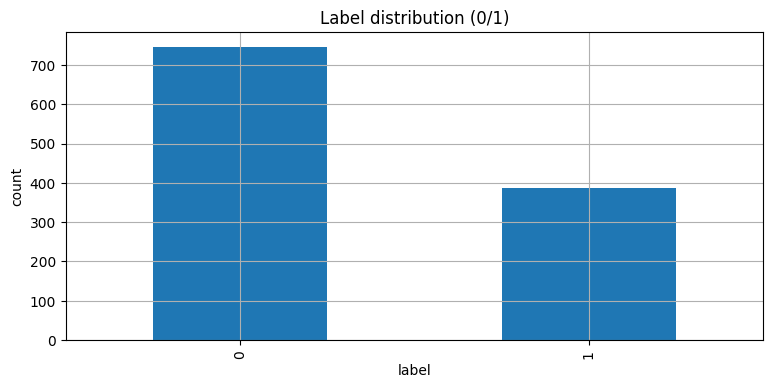

In [3]:

# --- Label distribution chart ---
if "label" in df.columns:
    fig = plt.figure()
    df["label"].value_counts().sort_index().plot(kind="bar")
    plt.title("Label distribution (0/1)")
    plt.xlabel("label")
    plt.ylabel("count")
    plt.show()
else:
    print("Колонки 'label' нет в данных.")


In [4]:

# --- Missing values summary ---
na = df.isna().sum().sort_values(ascending=False)
na = na[na > 0]
if not na.empty:
    display(na.head(30))
else:
    print("Пропусков нет (или уже очищены).")


Пропусков нет (или уже очищены).


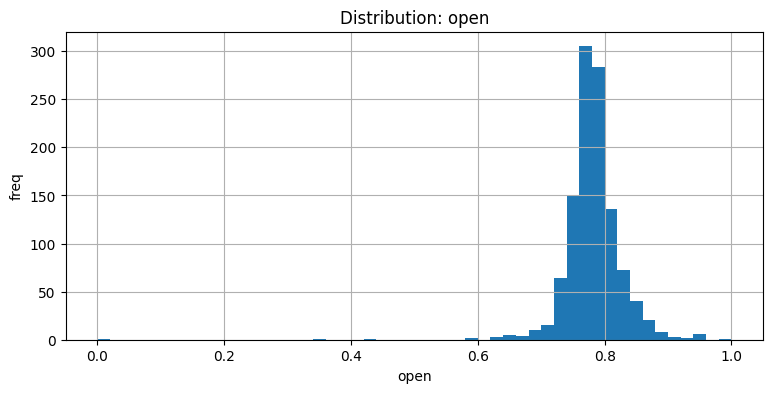

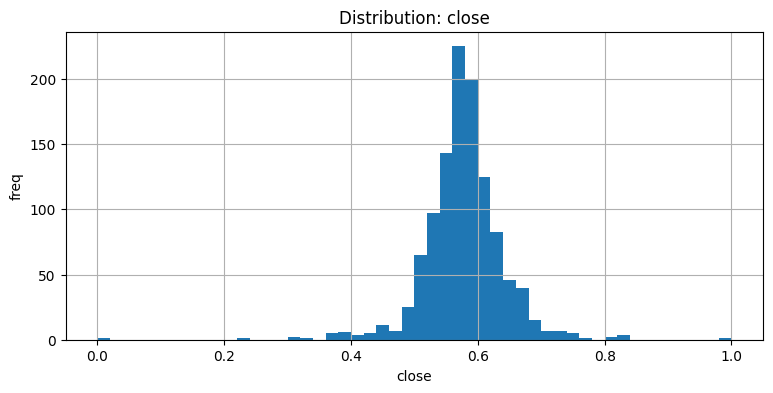

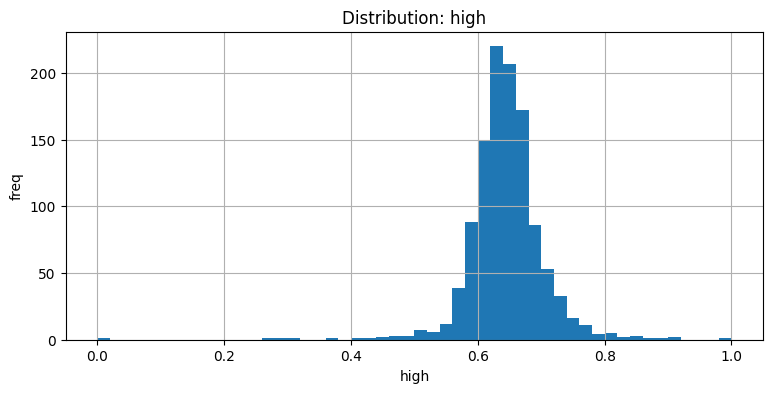

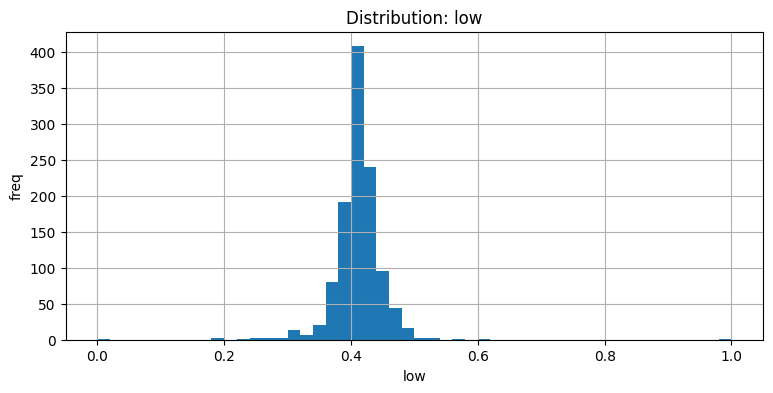

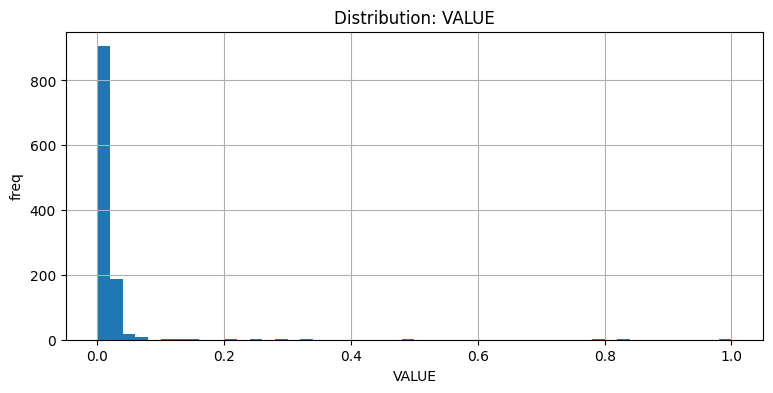

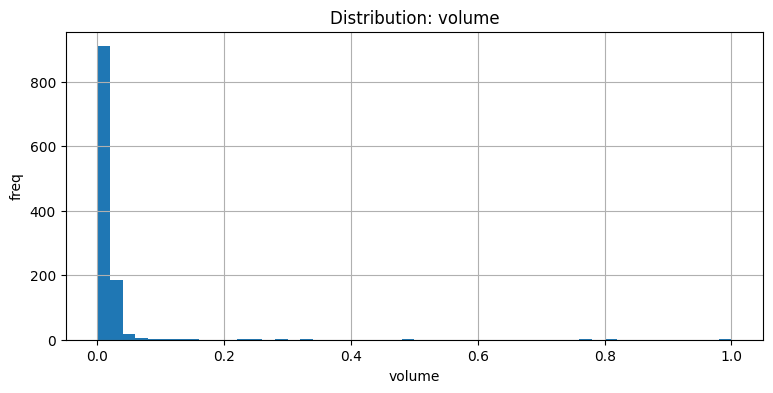

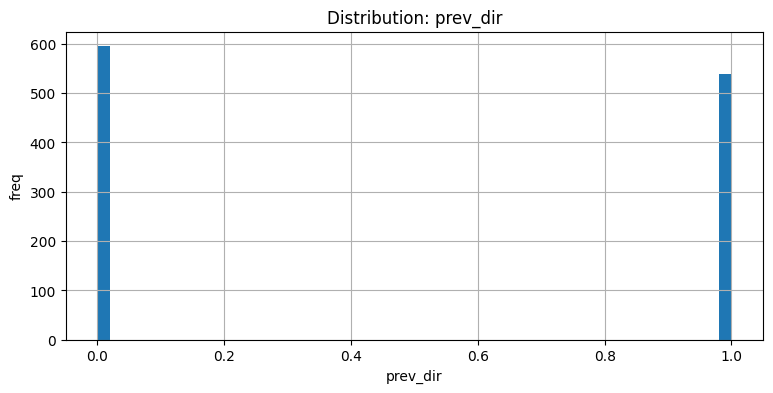

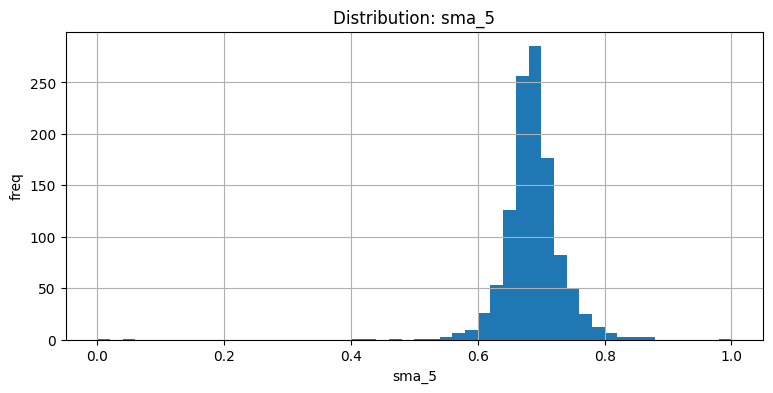

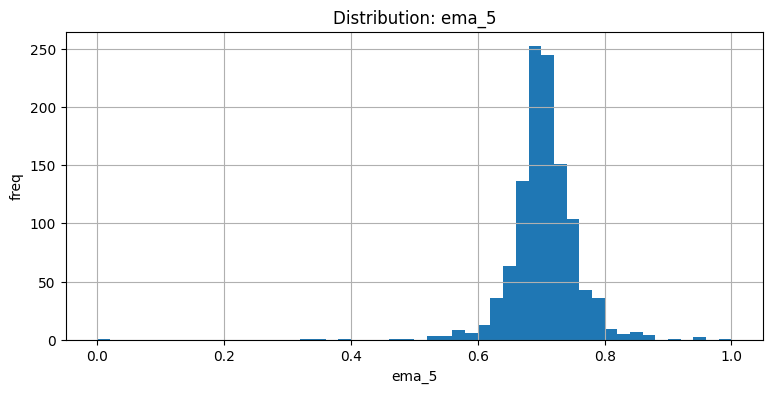

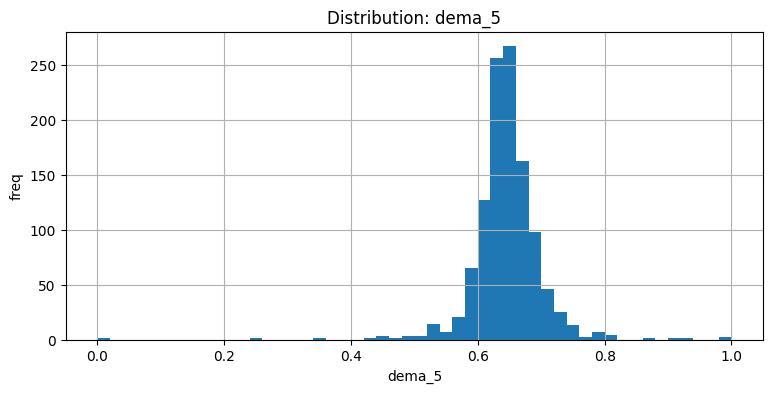

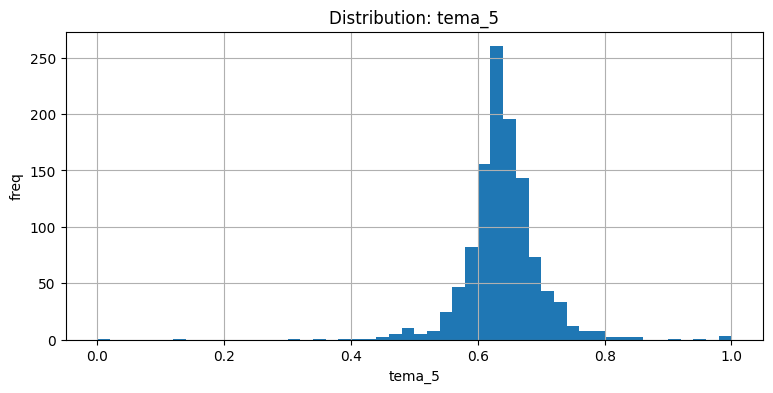

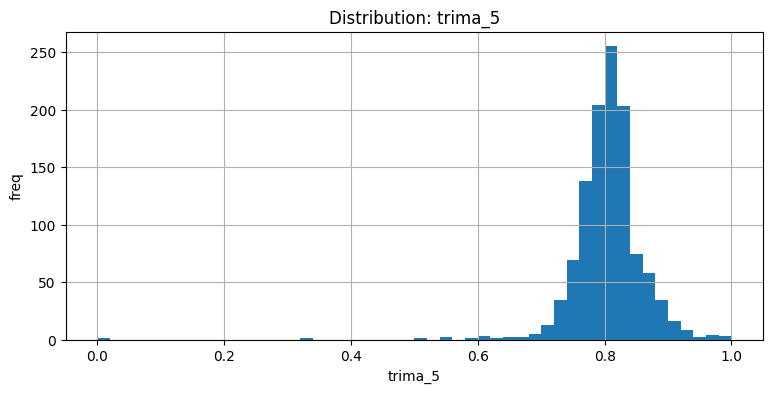

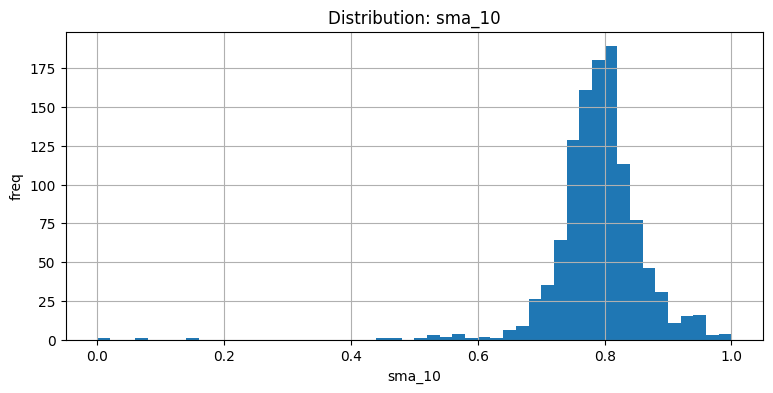

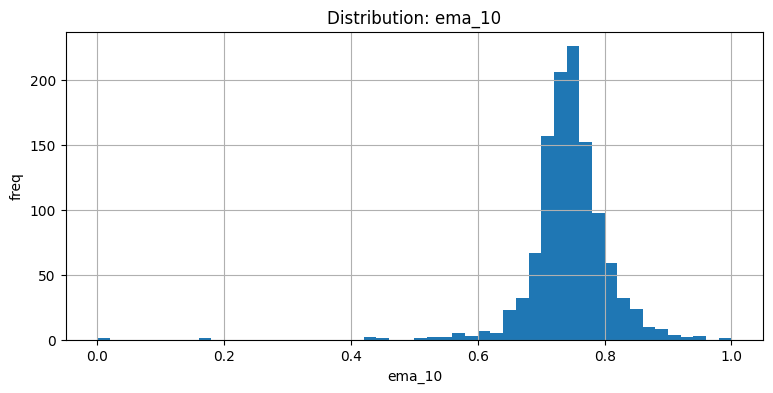

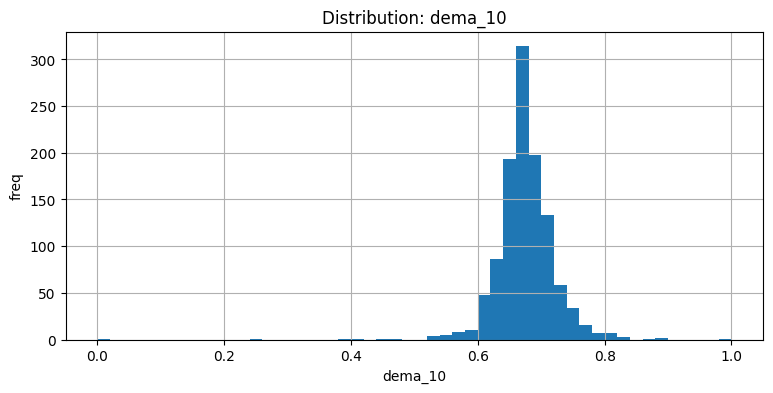

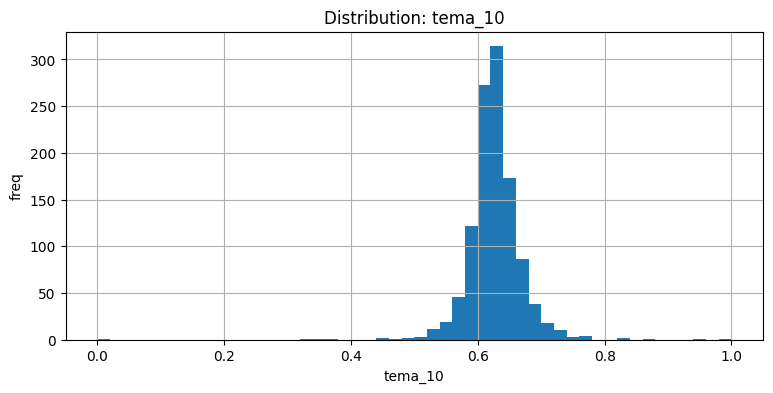

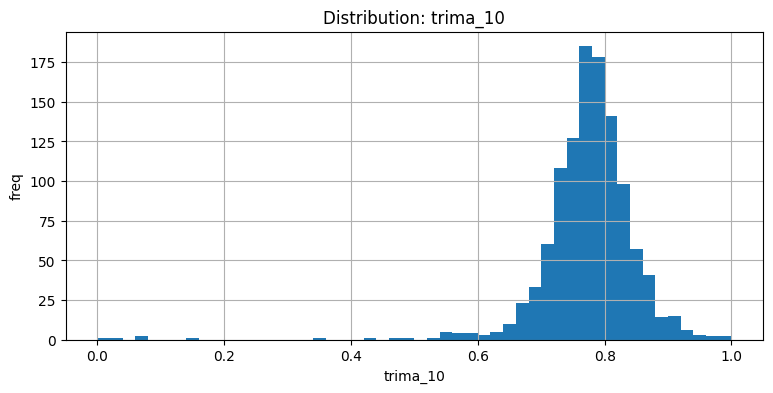

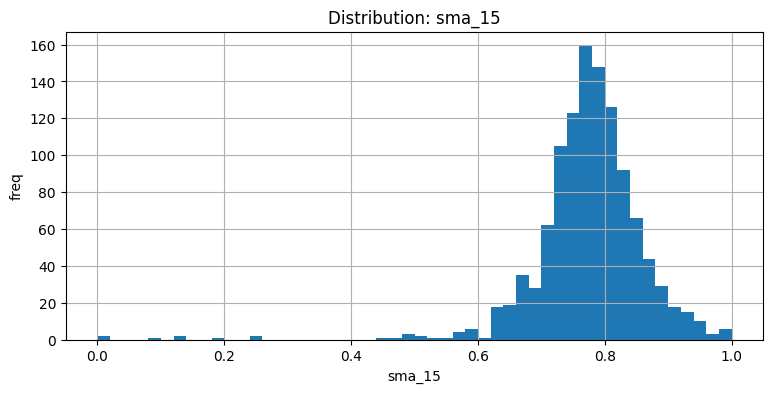

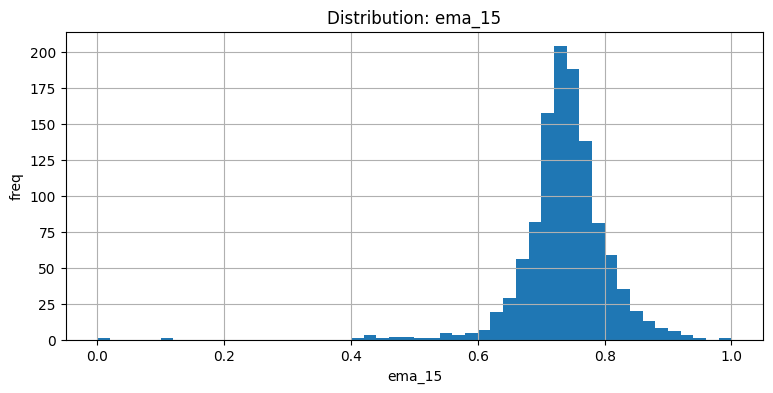

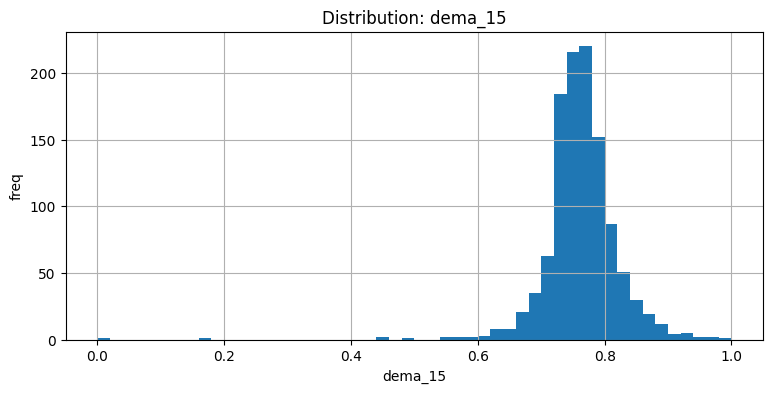

Показаны гистограммы первых 20 числовых признаков из 73.


In [5]:

# --- Feature histograms ---
features = num_features(df)
# ограничим число гистограмм, чтобы не убить ноут
MAX_HISTS = 20
for i, col in enumerate(features[:MAX_HISTS]):
    fig = plt.figure()
    vals = df[col].replace([np.inf, -np.inf], np.nan).dropna()
    if len(vals) == 0:
        continue
    plt.hist(vals, bins=50)
    plt.title(f"Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("freq")
    plt.show()
print(f"Показаны гистограммы первых {min(MAX_HISTS, len(features))} числовых признаков из {len(features)}.")


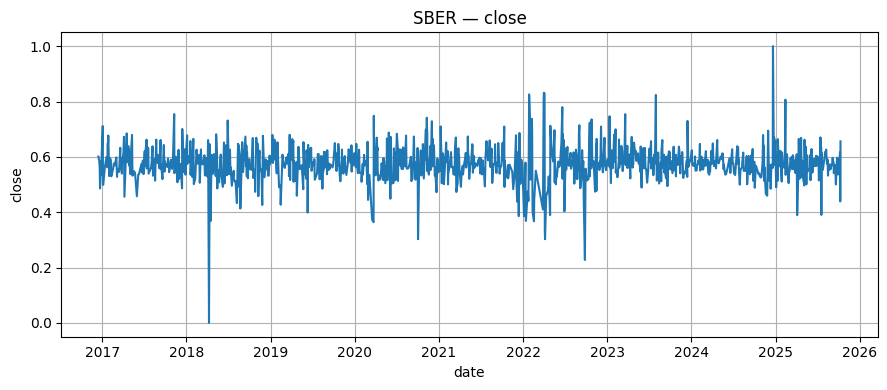

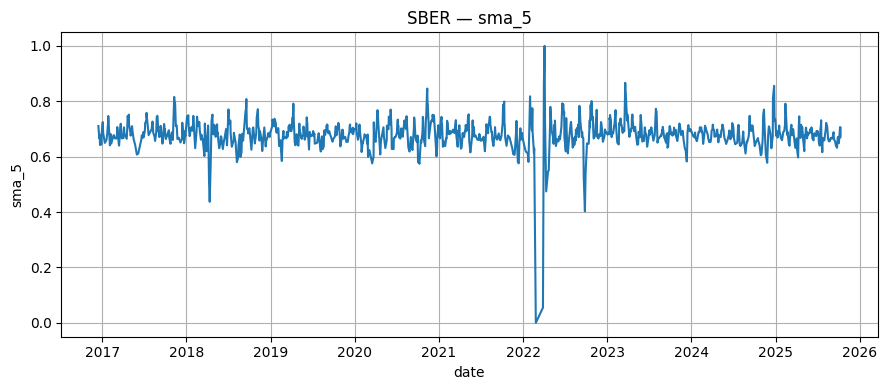

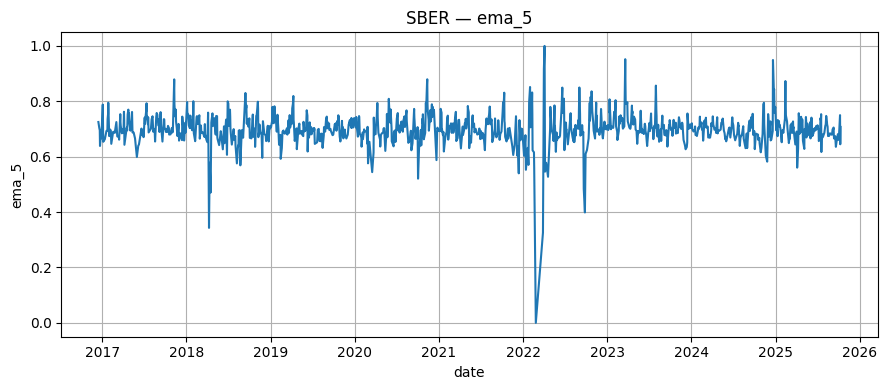

In [6]:

# --- Time series samples (per ticker) ---
if "ticker" in df.columns and "date" in df.columns:
    # Попробуем умные колонки для визуализации
    cand_cols = [c for c in df.columns if any(k in c.lower() for k in ["close","ret","pct","rsi","sma","ema"])]
    if not cand_cols:
        cand_cols = num_features(df)[:5]
    tickers = df["ticker"].dropna().unique().tolist()[:3]  # первые 3 тикера
    for t in tickers:
        g = df[df["ticker"] == t].sort_values("date")
        for col in cand_cols[:3]:  # до 3 колонок на тикер
            fig = plt.figure()
            plt.plot(g["date"].values, g[col].values)
            plt.title(f"{t} — {col}")
            plt.xlabel("date")
            plt.ylabel(col)
            plt.tight_layout()
            plt.show()
else:
    print("Нет колонок 'ticker'/'date' для временных рядов.")


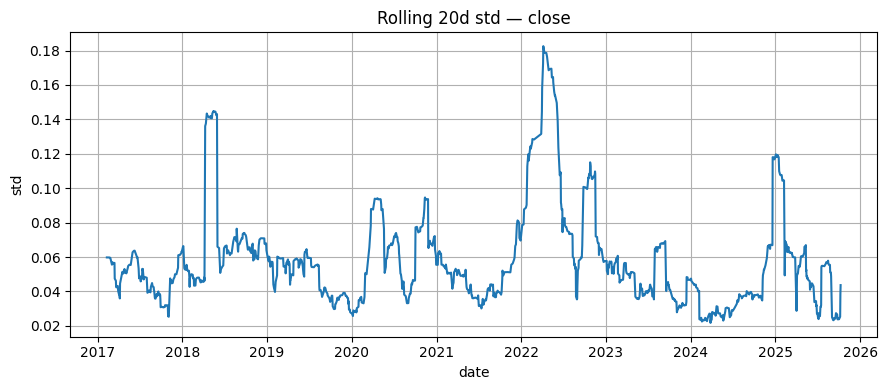

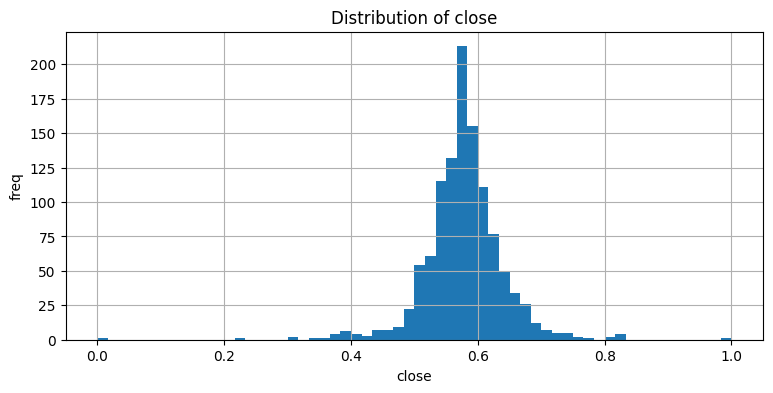

In [7]:

# --- Rolling volatility (std) для close-процентов, если есть ---
close_like = [c for c in df.columns if "close" in c.lower()]
target_col = None
for c in close_like:
    if c.endswith("_pct") or "pct" in c.lower() or df[c].abs().median() < 1.0:
        target_col = c
        break
# если не нашли, просто возьмем любую числовую колонку
if target_col is None:
    features = num_features(df)
    target_col = features[0] if features else None

if target_col and "date" in df.columns:
    if "ticker" in df.columns:
        t = df["ticker"].dropna().unique().tolist()[0]
        g = df[df["ticker"] == t].sort_values("date").copy()
    else:
        g = df.sort_values("date").copy()
    g["roll_std_20"] = g[target_col].rolling(20).std()
    fig = plt.figure()
    plt.plot(g["date"].values, g["roll_std_20"].values)
    plt.title(f"Rolling 20d std — {target_col}")
    plt.xlabel("date")
    plt.ylabel("std")
    plt.tight_layout()
    plt.show()

    # Гистограмма выбранного столбца
    fig = plt.figure()
    vals = g[target_col].replace([np.inf, -np.inf], np.nan).dropna()
    plt.hist(vals, bins=60)
    plt.title(f"Distribution of {target_col}")
    plt.xlabel(target_col)
    plt.ylabel("freq")
    plt.show()
else:
    print("Не удалось определить столбец для волатильности.")


In [8]:

# --- Autocorrelation (ACF) ---
if target_col is not None:
    if "ticker" in df.columns:
        t = df["ticker"].dropna().unique().tolist()[0]
        g = df[df["ticker"] == t].sort_values("date").copy()
        show_acf(g[target_col].dropna(), nlags=30, title=f"ACF — {t} — {target_col}")
    else:
        show_acf(df[target_col].dropna(), nlags=30, title=f"ACF — {target_col}")
else:
    print("Нет числового столбца для ACF.")


TypeError: stem() got an unexpected keyword argument 'use_line_collection'

<Figure size 900x400 with 0 Axes>

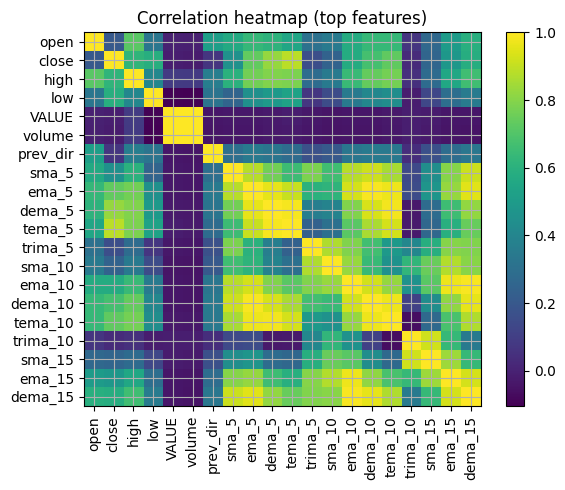

In [9]:

# --- Correlation heatmap (Top-N features) ---
NUM_FOR_HEATMAP = 20
features = num_features(df)
if features:
    use = features[:NUM_FOR_HEATMAP]
    corr = df[use].replace([np.inf, -np.inf], np.nan).dropna().corr()
    fig = plt.figure(figsize=(6,5))
    plt.imshow(corr.values, aspect='auto', interpolation='nearest')
    plt.colorbar()
    plt.title("Correlation heatmap (top features)")
    plt.xticks(range(len(use)), use, rotation=90)
    plt.yticks(range(len(use)), use)
    plt.tight_layout()
    plt.show()
else:
    print("Нет числовых признаков для тепловой карты.")


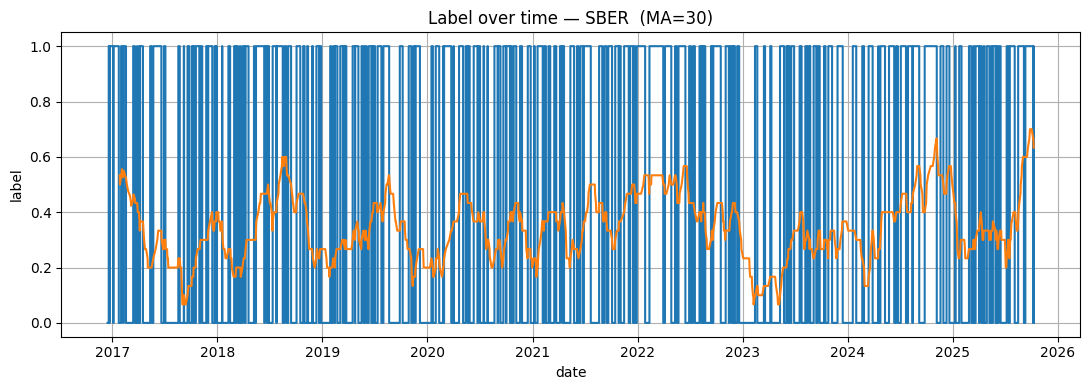

In [12]:
d = df.copy()
# приведение даты
d["date"] = pd.to_datetime(d["date"], errors="coerce")
d = d.dropna(subset=["date", "label"]).sort_values("date")

# таргет может быть {0,1} или {-1,1}; приведем к {0,1}, если нужно
uniq = pd.Series(d["label"].unique())
if set(uniq.dropna().astype(int)) == {-1, 1}:
    d["label"] = (d["label"] > 0).astype(int)
else:
    d["label"] = d["label"].astype(int)

# if ticker is not None and "ticker" in d.columns:
#     g = d[d["ticker"] == str(ticker)].copy()
title = f"Label over time — SBER"
# else:
#     # средний таргет по всем тикерам на дату
#     g = d.groupby("date", as_index=False)["label"].mean()
#     title = "Label over time — mean across tickers"

if g.empty:
    raise ValueError("Пустая выборка для указанного фильтра. Проверь 'ticker' и данные.")

# скользящее среднее по времени
g = g.sort_values("date").set_index("date")
g["label_ma"] = g["label"].rolling(30, min_periods=max(1, 30//2)).mean()

# график: шаговая линия для дискретной метки + MA
plt.figure(figsize=(11, 4))
# для дискретной метки берём drawstyle="steps-post"
plt.plot(g.index, g["label"].values, drawstyle="steps-post")
plt.plot(g.index, g["label_ma"].values)
plt.title(f"{title}  (MA={30})")
plt.xlabel("date")
plt.ylabel("label")
plt.grid(True)
plt.tight_layout()
plt.show()